In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data_dir = '../data/'
price_history_dir = data_dir + f'{data_dir}price_history/'
sentiment_dir = data_dir + f'{data_dir}sentiments/'
ti_dir = data_dir + f'{data_dir}technical_indicators/'

### Load Ticker Pair list

In [3]:
import glob

tickers_list = [file.split('/')[-1].strip('.csv') for file in glob.glob(price_history_dir + '*.csv')]
tickers_list
pairs_df = pd.read_csv(data_dir + 'ranked_pairs_snp.csv')
pairs = pairs_df[['ticker_0', 'ticker_1']].values

unique_pairs= pairs_df[['ticker_0', 'ticker_1']].drop_duplicates('ticker_0', keep='first').drop_duplicates('ticker_1', keep='first')

### Config Data From Files

In [4]:
ticker = 'AAPL'

price_history = pd.read_csv(price_history_dir + f'{ticker}.csv')
sentiment = pd.read_csv(sentiment_dir + f'{ticker}.csv')
ti = pd.read_csv(ti_dir + f'{ticker}.csv')

data = {}


class TickerData:
    def __init__(self, ticker):
        self.ticker = ticker
        self.history = pd.read_csv(price_history_dir + f'{ticker}.csv', index_col='Date', date_format='%Y-%m-%d')
        self.sentiment = pd.read_csv(sentiment_dir + f'{ticker}.csv', index_col='Date', date_format='%Y-%m-%d')
        self.ti = pd.read_csv(ti_dir + f'{ticker}.csv', index_col='Date', date_format='%Y-%m-%d')
    def __repr__(self):
        return repr(self.history['Adj Close'])

class DATA:
    pass

for ticker in tickers_list:
    setattr(DATA, ticker, TickerData(ticker))

    data[ticker] = TickerData(ticker)
    

In [5]:
display(DATA.AAPL.history.head(2))
display(DATA.AAPL.sentiment.head(2))
display(DATA.AAPL.ti.head(2))


,High,Low,Open,Volume,Adj Close
Date,,,,,
2021-01-04,133.6116,126.76,133.52,143301887.0,129.41
2021-01-05,131.7400,128.43,128.89,97664898.0,131.01


,news_pos_sentiment_count,news_sentiment_daily_avg,twitter_pos_sentiment_count
Date,,,
2021-01-01,11.0,0.0109,15
2021-01-04,3.0,-0.0008,6


,High,Low,Open,Volume,Adj Close,P,R1,R2,R3,S1,...,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-04,133.6116,126.76,133.52,143301887.0,129.41,129.927200,132.544511,134.161489,136.778800,127.309889,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,129.410000,0.00000,0.0000,0.00000
2021-01-05,131.7400,128.43,128.89,97664898.0,131.01,130.393333,131.657753,132.438913,133.703333,129.128913,...,0.098538,0.019708,0.078831,-2.60186,-0.520372,-2.081488,130.210469,1.23638,1.2288,1.23638


In [6]:
def add_moving_averages(df, moving_averages, columns):
    df = df.copy()
    for ma in moving_averages:
        for col in columns:
            new_col = f'{col}_ma{ma}'
            df[new_col] = df[col].rolling(window=ma).mean()
    # ffill na
    df.fillna(method='ffill', inplace=True)
    return df


### Load and Merge Data for Pair
change PAIR_IDX to the pair you want to analyze

In [7]:
PAIR_IDX = 0

pair = pairs[PAIR_IDX]

print(pair)

ADD_SENTIMENT_MA = True

# Join Sentiment and add Sentiment Moving Averages if ADD_SENTIMENT_MA is True
pair_sentiment_df = pd.merge(
    data[pair[0]].sentiment,
    data[pair[1]].sentiment,
    left_index=True,
    right_index=True,
    suffixes=("_S1", "_S2"),
)
if ADD_SENTIMENT_MA:
    pair_sentiment_df = add_moving_averages(
        pair_sentiment_df, [5, 10, 20], columns=pair_sentiment_df.columns
    )

# Join Technical Indicators
pair_ti_df = pd.merge(
    data[pair[0]].ti,
    data[pair[1]].ti,
    left_index=True,
    right_index=True,
    suffixes=("_S1", "_S2"),
)

pair_df = pd.merge(
    pair_ti_df, pair_sentiment_df, left_index=True, right_index=True, how="left"
)

print(pair_df.shape, pair_df.shape[0] * pair_df.shape[1])
pair_df

['GS' 'BLK']
(815, 268) 218420


/var/folders/l3/3msj1f8x6v930zvr96b6w9bh0000gn/T/ipykernel_77357/491297819.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


,High_S1,Low_S1,Open_S1,Volume_S1,Adj Close_S1,P_S1,R1_S1,R2_S1,R3_S1,S1_S1,...,twitter_pos_sentiment_count_S1_ma10,news_sentiment_daily_avg_S2_ma10,twitter_pos_sentiment_count_S2_ma10,news_pos_sentiment_count_S2_ma10,news_pos_sentiment_count_S1_ma20,news_sentiment_daily_avg_S1_ma20,twitter_pos_sentiment_count_S1_ma20,news_sentiment_daily_avg_S2_ma20,twitter_pos_sentiment_count_S2_ma20,news_pos_sentiment_count_S2_ma20
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-04,267.5800,260.16,267.00,3572043.0,265.00,264.246667,267.081107,268.832227,271.666667,261.412227,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-05,273.5000,262.57,263.88,4207081.0,270.93,269.000000,273.175260,275.754740,279.930000,264.824740,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-06,288.3800,273.10,276.29,6383530.0,285.55,282.343333,288.180293,291.786373,297.623333,276.506373,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-07,295.8894,286.68,287.77,4009730.0,291.65,291.406467,294.924457,297.097876,300.615867,287.888476,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-08,292.2800,285.06,292.00,2800784.0,290.08,289.140000,291.898040,293.601960,296.360000,286.381960,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-25,410.4600,403.86,406.87,1683977.0,404.94,406.420000,408.941200,410.498800,413.020000,403.898800,...,13.5,-0.00518,26.0,0.9,1.65,0.013955,11.05,-0.002305,45.75,1.10
2024-03-26,409.3300,404.52,406.09,1406974.0,406.18,406.676667,408.514087,409.649247,411.486667,404.839247,...,14.1,-0.00433,25.3,0.9,1.65,0.013535,11.55,-0.003410,42.35,0.95
2024-03-27,415.4900,408.37,409.62,2353629.0,415.25,413.036667,415.756507,417.436827,420.156667,410.316827,...,15.6,-0.00290,22.1,1.0,1.55,0.013875,11.80,-0.003270,38.50,1.00



### calculate spread


<Axes: title={'center': 'Spread'}, xlabel='Date'>

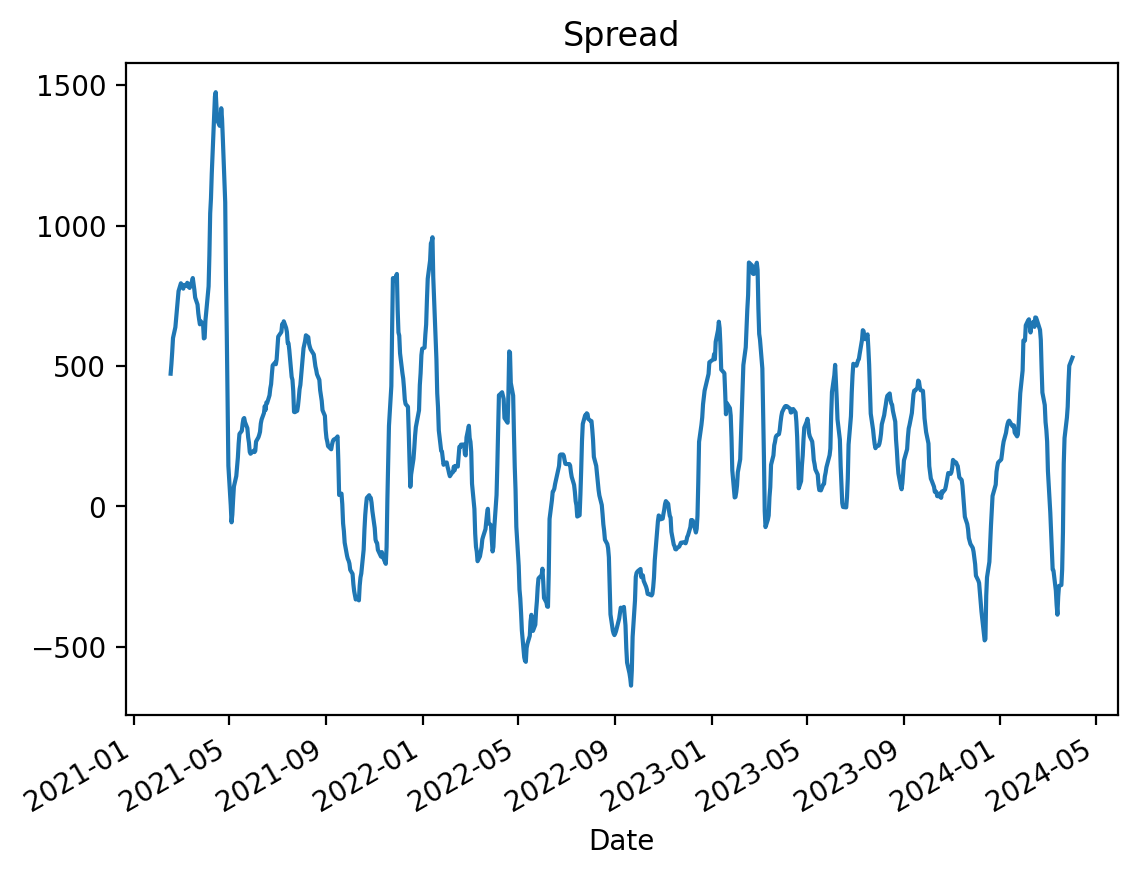

In [8]:
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS

# If window param is set, then spread is calculated on a rolling basis
def get_spread(S1, S2, window=None):
    s1_ols = sm.add_constant(S1)
    if window:
        spread_model = sm.regression.rolling.RollingOLS(S2, s1_ols, window=window).fit()
    else:
        spread_model = sm.OLS(S2, s1_ols).fit()
    beta = spread_model.params[S1.name]
    spread = S2 - beta * S1
    return spread


def norm_plot(df):
    df=df.copy()
    df = (df - df.mean()) / df.std()
    return df



SPREAD_WINDOW = 30
spread = get_spread(pair_df['Adj Close_S1'], pair_df['Adj Close_S2'], window=SPREAD_WINDOW)
pair_df['spread'] = spread

pair_df['spread'].plot(title='Spread')


### Create Target 

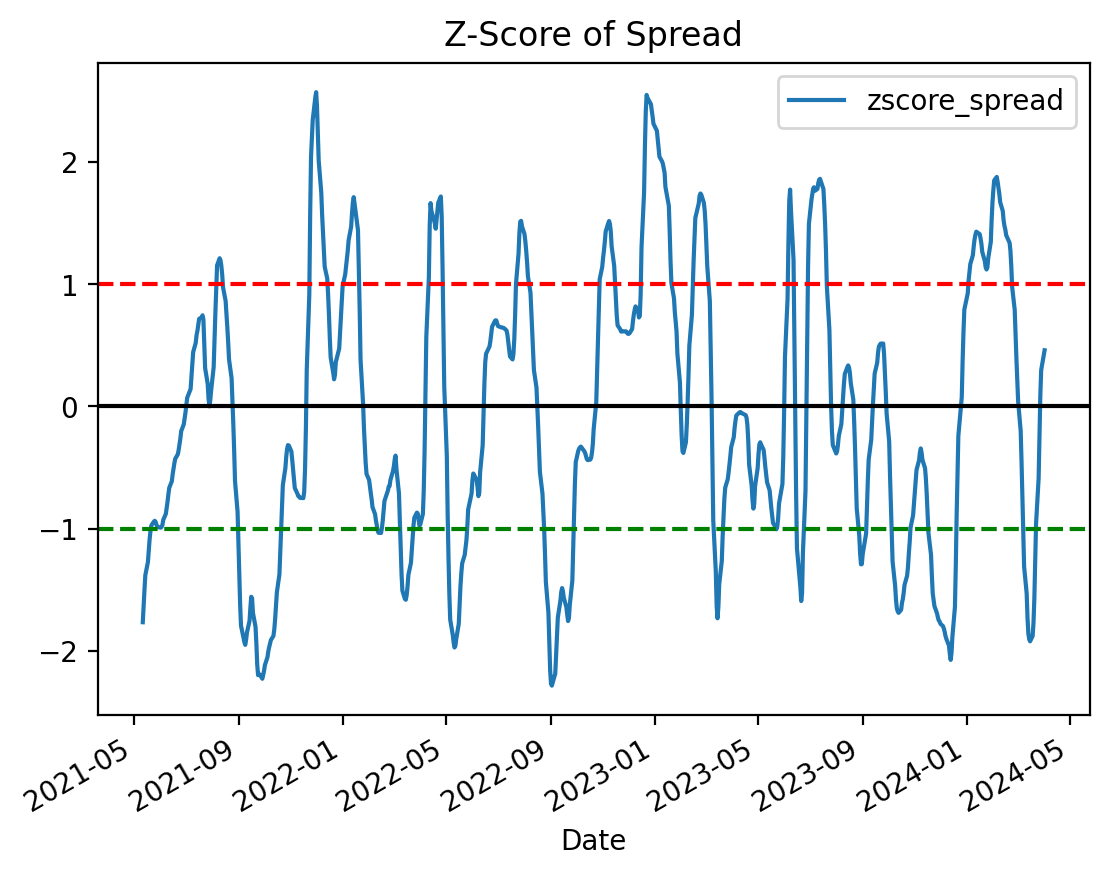

,High_S1,Low_S1,Open_S1,Volume_S1,Adj Close_S1,P_S1,R1_S1,R2_S1,R3_S1,S1_S1,...,twitter_pos_sentiment_count_S2_ma10,news_pos_sentiment_count_S2_ma10,news_pos_sentiment_count_S1_ma20,news_sentiment_daily_avg_S1_ma20,twitter_pos_sentiment_count_S1_ma20,news_sentiment_daily_avg_S2_ma20,twitter_pos_sentiment_count_S2_ma20,news_pos_sentiment_count_S2_ma20,spread,zscore_spread
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-04,267.5800,260.16,267.00,3572043.0,265.00,264.246667,267.081107,268.832227,271.666667,261.412227,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-05,273.5000,262.57,263.88,4207081.0,270.93,269.000000,273.175260,275.754740,279.930000,264.824740,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-06,288.3800,273.10,276.29,6383530.0,285.55,282.343333,288.180293,291.786373,297.623333,276.506373,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-07,295.8894,286.68,287.77,4009730.0,291.65,291.406467,294.924457,297.097876,300.615867,287.888476,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-08,292.2800,285.06,292.00,2800784.0,290.08,289.140000,291.898040,293.601960,296.360000,286.381960,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-25,410.4600,403.86,406.87,1683977.0,404.94,406.420000,408.941200,410.498800,413.020000,403.898800,...,26.0,0.9,1.65,0.013955,11.05,-0.002305,45.75,1.10,316.252027,-0.589350
2024-03-26,409.3300,404.52,406.09,1406974.0,406.18,406.676667,408.514087,409.649247,411.486667,404.839247,...,25.3,0.9,1.65,0.013535,11.55,-0.003410,42.35,0.95,355.088343,-0.230625
2024-03-27,415.4900,408.37,409.62,2353629.0,415.25,413.036667,415.756507,417.436827,420.156667,410.316827,...,22.1,1.0,1.55,0.013875,11.80,-0.003270,38.50,1.00,440.909442,0.094234


In [9]:

# We want to predict the z-score of spread, to forecast deviations from the mean

# The Z-score of the spread will be used to determine when to buy and sell
# We use a low/high moving average to calculate the z-score. 
# This is so that the z-score is not affected by the spread increasing over time
# Can play around with the window sizes to see what works best

# Moving Z score Calculation (Trading Signal)
ma_high = pair_df.spread.rolling(window=60).mean()
ma_low = pair_df.spread.rolling(window=5).mean()
std_high = pair_df.spread.rolling(window=60).std()

moving_zscore = (ma_low - ma_high) / std_high
pair_df['zscore_spread'] = moving_zscore


pair_df['zscore_spread'].plot(title='Z-Score of Spread')
plt.axhline(0, color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend()
plt.show()
pair_df

In [10]:
plt.style.use('custom_onedark')



In [11]:
pip install tabulate

Note: you may need to restart the kernel to use updated packages.


In [12]:
from tabulate import tabulate
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error


def create_dataset(data, look_back, target_col="spread_close", split_sizes=[0.6, 0.2, 0.2], drop_cols: list = []):
    data = data.copy().dropna()
    y = data[target_col]
    y_shifted = y.shift(-look_back)

    data["target"] = y_shifted
    data = data.dropna().drop(drop_cols, axis=1)
    train_size = int(len(data) * split_sizes[0])
    val_size = int(len(data) * split_sizes[1])
    test_size = len(data) - train_size - val_size



    print("------Dataset Information------")
    print(tabulate([
            ["Train", train_size, data.index[train_size].date()], 
            ["Val", val_size, data.index[-val_size].date()],
            ["Test", test_size, data.index[-test_size].date()]],
        ["Set", "Size", "Date Cutoff"]))

    train_data = data.iloc[:train_size]
    val_data = data.iloc[train_size : train_size + val_size]
    test_data = data.iloc[-test_size:]
    return train_data, val_data, test_data


def prepare_dataset(train_data, val_data, test_data):
    X_train, y_train = train_data.drop(columns=["target"]), train_data["target"]
    X_val, y_val = val_data.drop(columns=["target"]), val_data["target"]
    X_test, y_test = test_data.drop(columns=["target"]), test_data["target"]

    return X_train, y_train, X_val, y_val, X_test, y_test



## Dataset Setup

In [22]:
# Parameters
LOOK_BACK = 3
DROP_COLS = [
   
]

train_data, val_data, test_data = create_dataset(
    pair_df, 
    look_back=LOOK_BACK, 
    target_col="zscore_spread", 
    drop_cols=DROP_COLS
)

X_train, y_train, X_val, y_val, X_test, y_test = prepare_dataset(train_data, val_data, test_data)

# Combine val and test data since were not using Deep learning or hyper-param tuning 
X_test = pd.concat([X_val, X_test])
y_test = pd.concat([y_val, y_test])

------Dataset Information------
Set      Size  Date Cutoff
-----  ------  -------------
Train     506  2023-05-15
Val       144  2023-08-29
Test       73  2023-12-08


In [23]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

def calculate_metrics(y_true, y_pred):
    metric_frame = {
        "mape": mean_absolute_percentage_error(y_true, y_pred),
        "mse": mean_squared_error(y_true, y_pred),
        "mae": mean_absolute_error(y_true, y_pred),
        "r2": r2_score(y_true, y_pred)
    }
    print(f"\nR2: {metric_frame['r2']:.2f}, MAE: {metric_frame['mae']:.2f}, MAPE: {metric_frame['mape']*100:.2f}%")
    return metric_frame


R2: -2.31, MAE: 1.54, MAPE: 576.72%


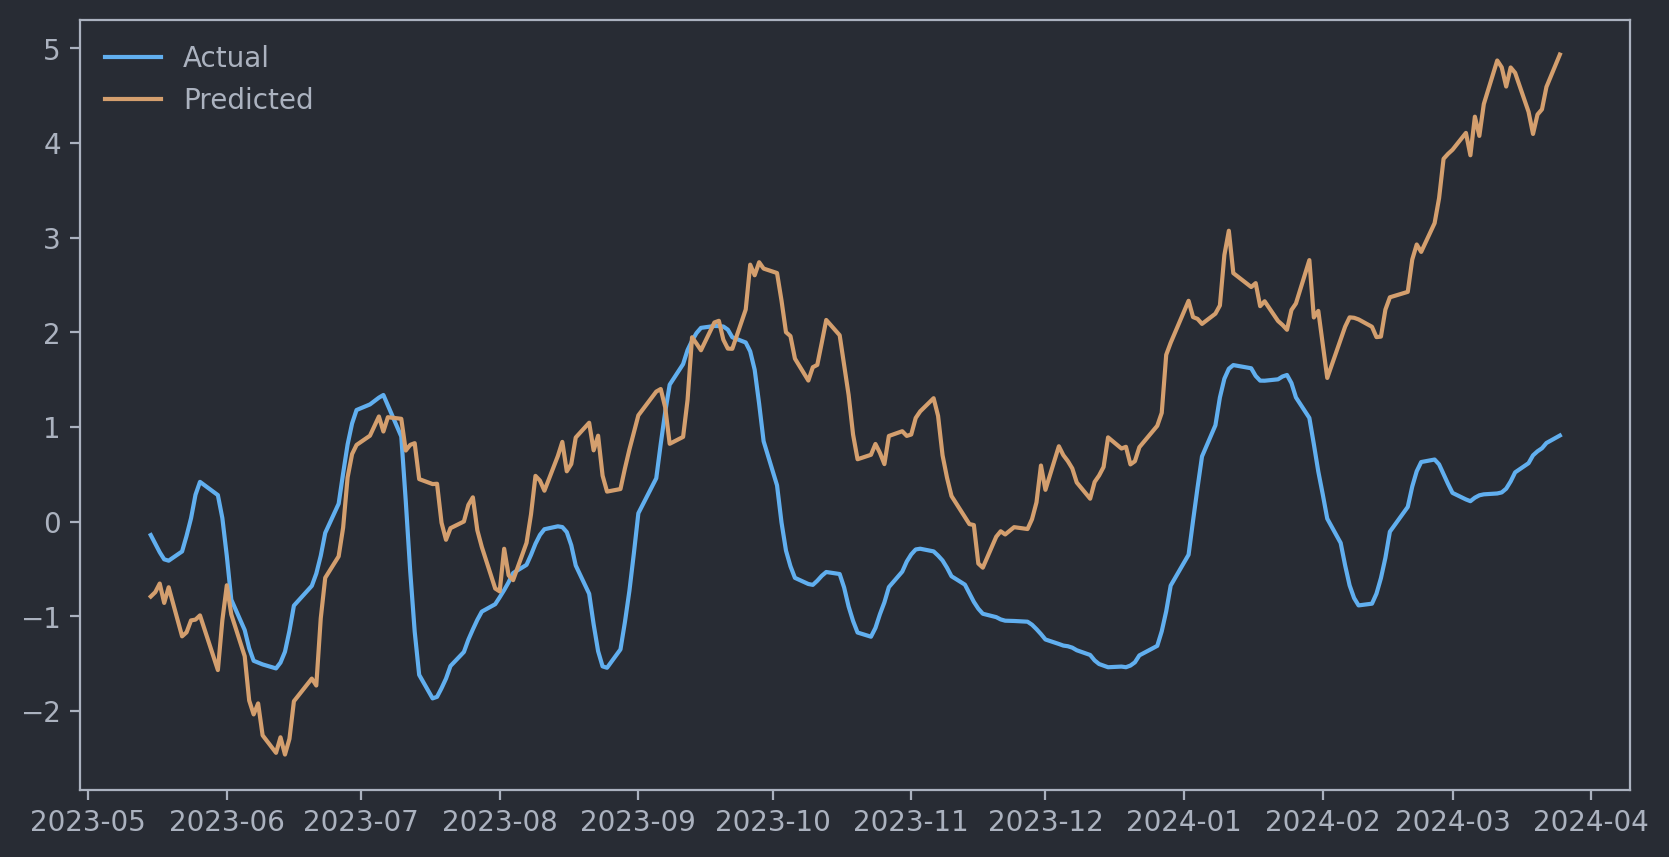

In [24]:
# ---- Model Training ----
model_reg = LinearRegression()
model_reg.fit(X_train, y_train)

y_pred = model_reg.predict(X_test)

model_results = {}
model_results['Vanilla Regression'] = calculate_metrics(y_test, y_pred)


fig = plt.figure(figsize=(10, 5))
plt.plot(y_test.index, y_test, label="Actual")
plt.plot(y_test.index, y_pred, label="Predicted")
plt.legend()

# get feature importance
feature_importance = model_reg.coef_
features = X_train.columns
feature_importance_df = pd.DataFrame({"feature": features, "importance": feature_importance})
feature_importance_df = feature_importance_df.sort_values("importance", ascending=False)

In [25]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

model_gbr = GradientBoostingRegressor()
model_gbr.fit(X_train, y_train)
y_pred = model_gbr.predict(X_test)
model_results['Gradient Boosting Regressor'] = calculate_metrics(
    y_test, y_pred)

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f"\nR2: {r2:.2f}, MAE: {mae:.2f}")



R2: 0.59, MAE: 0.51, MAPE: 195.70%

R2: 0.59, MAE: 0.51


In [69]:
print('Original Feature Dim:', feature_importance_df.shape[0])

# Can Change Thresholds, By no means are these the best thresholds
# Should use another method for feature selection, this was just for demonstration
low_importance_df = feature_importance_df[(feature_importance_df['importance'] < 1) & (feature_importance_df['importance'] > -1)]
print('Low Importance Feature Dim:', low_importance_df.shape[0])

low_importance_cols = low_importance_df.feature.to_list()
high_importance_df = feature_importance_df[(feature_importance_df['importance'] >= 1) | (feature_importance_df['importance'] <= -1)]

Original Feature Dim: 252
Low Importance Feature Dim: 241


### Train regression again with low importance columns removed

In [17]:

train_data, val_data, test_data = create_dataset(
    pair_df, 
    look_back=LOOK_BACK, 
    target_col="zscore_spread", 
    drop_cols=low_importance_cols
)

X_train, y_train, X_val, y_val, X_test, y_test = prepare_dataset(train_data, val_data, test_data)

# Combine val and test data since were not using Deep learning or hyper-param tuning 
X_test = pd.concat([X_val, X_test])
y_test = pd.concat([y_val, y_test])



model_reg = LinearRegression()
model_reg.fit(X_train, y_train)

y_pred = model_reg.predict(X_test)


model_results['Regression with Feature Selection'] = calculate_metrics(y_test, y_pred)

fig = plt.figure(figsize=(10, 5))
plt.plot(y_test.index, y_test, label="Actual")
plt.plot(y_test.index, y_pred, label="Predicted")
plt.legend()

plt.show()

NameError: name 'low_importance_cols' is not defined

# General Setup

In [18]:
def add_moving_averages(df, moving_averages, columns):
    df = df.copy()
    for ma in moving_averages:
        for col in columns:
            new_col = f'{col}_ma{ma}'
            df[new_col] = df[col].rolling(window=ma).mean()
    # ffill na
    df.fillna(method='ffill', inplace=True)
    return df

# If window param is set, then spread is calculated on a rolling basis
def get_spread(S1, S2, window=None):
    s1_ols = sm.add_constant(S1)
    if window:
        spread_model = sm.regression.rolling.RollingOLS(S2, s1_ols, window=window).fit()
    else:
        spread_model = sm.OLS(S2, s1_ols).fit()
    beta = spread_model.params[S1.name]
    spread = S2 - beta * S1
    return spread


def norm_plot(df):
    df=df.copy()
    df = (df - df.mean()) / df.std()
    return df

from tabulate import tabulate
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error


def create_dataset(data, look_back, target_col="spread_close", split_sizes=[0.6, 0.2, 0.2], drop_cols: list = []):
    data = data.copy().dropna()
    y = data[target_col]
    y_shifted = y.shift(-look_back)

    data["target"] = y_shifted
    data = data.dropna().drop(drop_cols, axis=1)
    train_size = int(len(data) * split_sizes[0])
    val_size = int(len(data) * split_sizes[1])
    test_size = len(data) - train_size - val_size



    print("------Dataset Information------")
    print(tabulate([
            ["Train", train_size, data.index[train_size].date()], 
            ["Val", val_size, data.index[-val_size].date()],
            ["Test", test_size, data.index[-test_size].date()]],
        ["Set", "Size", "Date Cutoff"]))

    train_data = data.iloc[:train_size]
    val_data = data.iloc[train_size : train_size + val_size]
    test_data = data.iloc[-test_size:]
    return train_data, val_data, test_data


def prepare_dataset(train_data, val_data, test_data):
    X_train, y_train = train_data.drop(columns=["target"]), train_data["target"]
    X_val, y_val = val_data.drop(columns=["target"]), val_data["target"]
    X_test, y_test = test_data.drop(columns=["target"]), test_data["target"]

    return X_train, y_train, X_val, y_val, X_test, y_test



['JPM' 'CRM']
------Dataset Information------
Set      Size  Date Cutoff
-----  ------  -------------
Train     450  2023-01-11
Val       150  2023-08-17
Test      150  2023-08-17

R2: -13.32, MAE: 3.20, MAPE: 1249.33%


/var/folders/l3/3msj1f8x6v930zvr96b6w9bh0000gn/T/ipykernel_77357/3152546308.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


,High_S1,Low_S1,Open_S1,Volume_S1,Adj Close_S1,P_S1,R1_S1,R2_S1,R3_S1,S1_S1,...,news_sentiment_daily_avg_S2_ma10,twitter_pos_sentiment_count_S2_ma10,news_pos_sentiment_count_S1_ma20,news_sentiment_daily_avg_S1_ma20,twitter_pos_sentiment_count_S1_ma20,news_pos_sentiment_count_S2_ma20,news_sentiment_daily_avg_S2_ma20,twitter_pos_sentiment_count_S2_ma20,spread,zscore_spread
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-04,127.8579,124.7800,127.50,16819915.0,125.87,126.169300,127.345058,128.071442,129.247200,124.993542,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-34.506406,NaN
2021-01-05,126.2995,123.7700,124.99,13731206.0,125.65,125.239833,126.206102,126.803064,127.769333,124.273564,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-32.851029,NaN
2021-01-06,132.7700,127.8800,129.88,24909056.0,131.55,130.733333,132.601313,133.755353,135.623333,128.865353,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-50.165232,NaN
2021-01-07,138.1900,134.9200,135.69,21940387.0,135.87,136.326667,137.575807,138.347527,139.596667,135.077527,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-57.080818,NaN
2021-01-08,136.3500,134.1200,135.97,12035126.0,136.02,135.496667,136.348527,136.874807,137.726667,134.644807,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-53.324484,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-25,196.9400,194.3600,196.60,8620015.0,194.82,195.373333,196.358893,196.967773,197.953333,194.387773,...,0.03766,0.2,2.65,-0.044410,5.65,4.65,0.047840,5.40,-88.341623,-1.505957
2024-03-26,196.6600,194.0554,194.59,5961484.0,195.73,195.481800,196.476757,197.091443,198.086400,194.486843,...,0.02824,0.4,2.85,-0.045265,5.75,4.40,0.038605,5.25,-90.413865,-1.454960
2024-03-27,199.6000,196.3800,196.50,8725757.0,199.52,198.500000,199.730040,200.489960,201.720000,197.269960,...,0.00437,0.4,2.75,-0.044890,5.75,4.30,0.037945,5.00,-102.536497,-1.555702


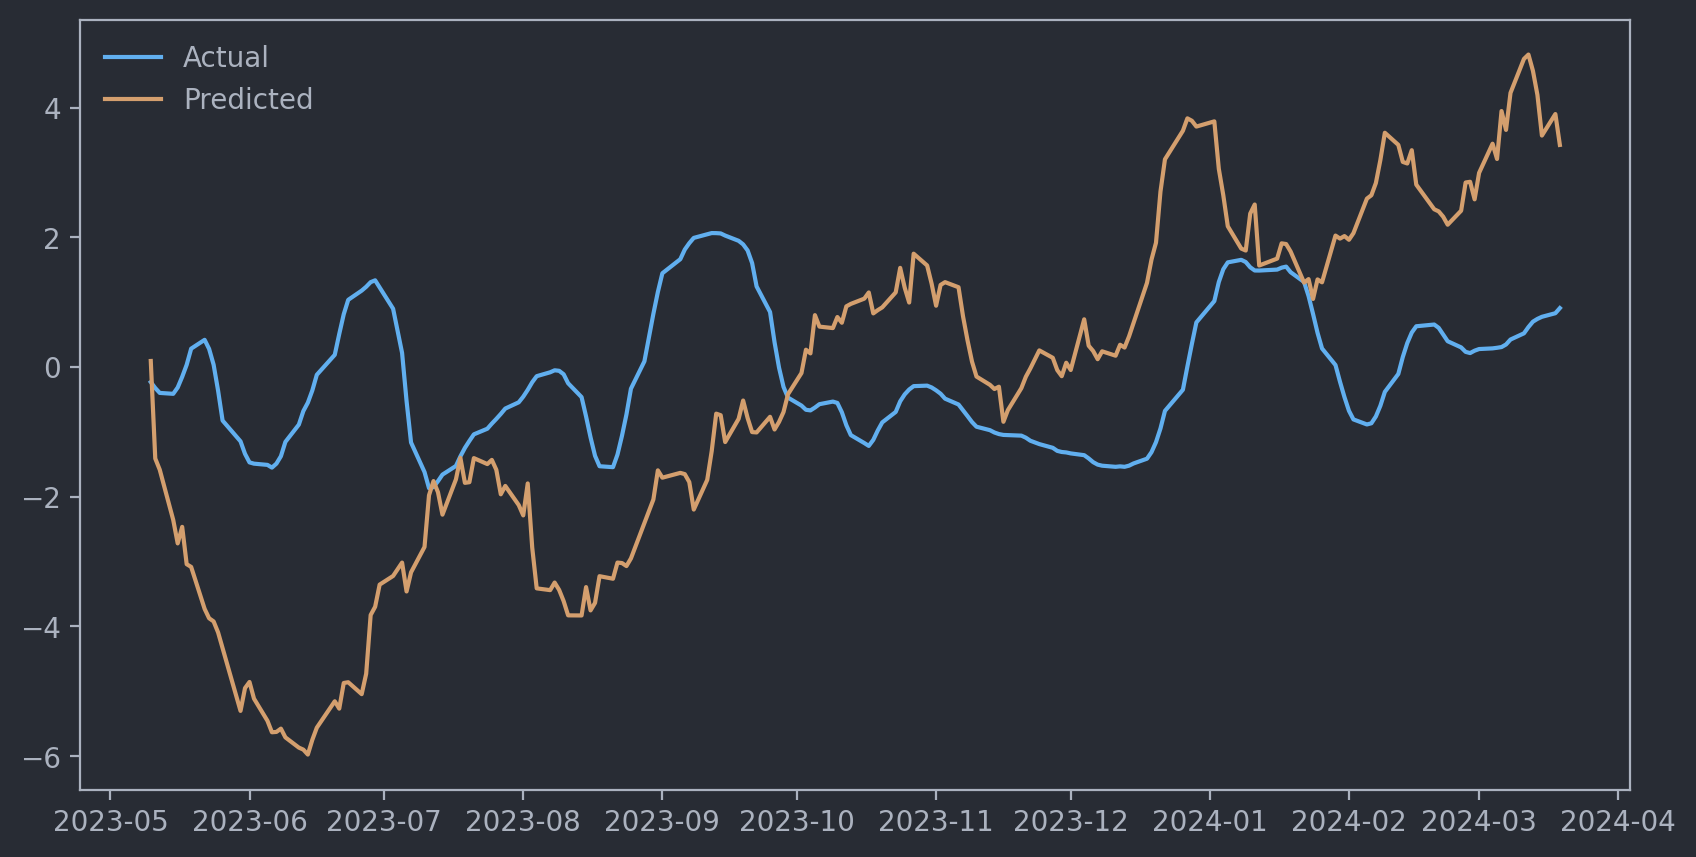

In [19]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS



data_dir = '../data/'
price_history_dir = data_dir + f'{data_dir}price_history/'
sentiment_dir = data_dir + f'{data_dir}sentiments/'
ti_dir = data_dir + f'{data_dir}technical_indicators/'

import glob

# Load Ticker Pairs
tickers_list = [file.split('/')[-1].strip('.csv') for file in glob.glob(price_history_dir + '*.csv')]
pairs_df = pd.read_csv(data_dir + 'ranked_pairs_snp.csv')
pairs = pairs_df[['ticker_0', 'ticker_1']].values
unique_pairs= pairs_df[['ticker_0', 'ticker_1']].drop_duplicates('ticker_0', keep='first').drop_duplicates('ticker_1', keep='first')


# Load Ticker History, Sentiment and Technical Indicators
data = {}
class TickerData:
    def __init__(self, ticker):
        self.ticker = ticker
        self.history = pd.read_csv(price_history_dir + f'{ticker}.csv', index_col='Date', date_format='%Y-%m-%d')
        self.sentiment = pd.read_csv(sentiment_dir + f'{ticker}.csv', index_col='Date', date_format='%Y-%m-%d')
        self.ti = pd.read_csv(ti_dir + f'{ticker}.csv', index_col='Date', date_format='%Y-%m-%d')
    def __repr__(self):
        return repr(self.history['Adj Close'])

class DATA:
    pass

for ticker in tickers_list:
    setattr(DATA, ticker, TickerData(ticker))

    data[ticker] = TickerData(ticker)



# Pair Selection
PAIR_IDX = 1
ADD_SENTIMENT_MA = True


pair = pairs[PAIR_IDX]
print(pair)

# Join Sentiment and add Sentiment Moving Averages if ADD_SENTIMENT_MA is True
pair_sentiment_df = pd.merge( data[pair[0]].sentiment, data[pair[1]].sentiment, left_index=True, right_index=True, suffixes=("_S1", "_S2"),)
if ADD_SENTIMENT_MA:
    pair_sentiment_df = add_moving_averages(pair_sentiment_df, [5, 10, 20], columns=pair_sentiment_df.columns)

# Join Technical Indicators
pair_ti_df = pd.merge( data[pair[0]].ti, data[pair[1]].ti, left_index=True, right_index=True, suffixes=("_S1", "_S2"))
pair_df = pd.merge(pair_ti_df, pair_sentiment_df, left_index=True, right_index=True, how="left")



# ---- Dataset Setup ----
# We want to predict the z-score of spread, to forecast deviations from the mean

# The Z-score of the spread will be used to determine when to buy and sell
# We use a low/high moving average to calculate the z-score. 
# This is so that the z-score is not affected by the spread increasing over time
# Can play around with the window sizes to see what works best

SPREAD_WINDOW = None
MA_HIGH = 60
MA_LOW = 5

# Parameters
LOOK_BACK = 5
DROP_COLS = [

]
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

def calculate_metrics(y_true, y_pred):
    metric_frame = {
        "mape": mean_absolute_percentage_error(y_true, y_pred),
        "mse": mean_squared_error(y_true, y_pred),
        "mae": mean_absolute_error(y_true, y_pred),
        "r2": r2_score(y_true, y_pred)
    }
    print(f"\nR2: {metric_frame['r2']:.2f}, MAE: {metric_frame['mae']:.2f}, MAPE: {metric_frame['mape']*100:.2f}%")
    return metric_frame


spread = get_spread(pair_df['Adj Close_S1'], pair_df['Adj Close_S2'], window=SPREAD_WINDOW)
pair_df['spread'] = spread

# Calculate Moving Z score Calculation (Trading Signal)
ma_high = pair_df.spread.rolling(window=MA_HIGH).mean()
ma_low = pair_df.spread.rolling(window=MA_LOW).mean()
std_high = pair_df.spread.rolling(window=MA_HIGH).std()

moving_zscore = (ma_low - ma_high) / std_high
pair_df['zscore_spread'] = moving_zscore


train_data, val_data, test_data = create_dataset(
    pair_df, 
    look_back=LOOK_BACK, 
    target_col="zscore_spread", 
    drop_cols=DROP_COLS
)

X_train, y_train, X_val, y_val, X_test, y_test = prepare_dataset(train_data, val_data, test_data)

# Combine val and test data since were not using Deep learning or hyper-param tuning 
X_test = pd.concat([X_val, X_test])
y_test = pd.concat([y_val, y_test])

model_reg = LinearRegression()
model_reg.fit(X_train, y_train)

y_pred = model_reg.predict(X_test)

model_results = {}
model_results['Vanilla Regression'] = calculate_metrics(y_test, y_pred)


fig = plt.figure(figsize=(10, 5))
plt.plot(y_test.index, y_test, label="Actual")
plt.plot(y_test.index, y_pred, label="Predicted")
plt.legend()

# --- Feature Selection Setup ---


# # get feature importance
# feature_importance = model_reg.coef_
# features = X_train.columns
# feature_importance_df = pd.DataFrame({"feature": features, "importance": feature_importance})
# feature_importance_df = feature_importance_df.sort_values("importance", ascending=False)
# print('Original Feature Dim:', feature_importance_df.shape[0])

# # Can Change Thresholds, By no means are these the best thresholds
# # Should use another method for feature selection, this was just for demonstration
# low_importance_df = feature_importance_df[(feature_importance_df['importance'] < 1) & (feature_importance_df['importance'] > -1)]
# print('Low Importance Feature Dim:', low_importance_df.shape[0])

# low_importance_cols = low_importance_df.feature.to_list()
# high_importance_df = feature_importance_df[(feature_importance_df['importance'] >= 1) | (feature_importance_df['importance'] <= -1)]

# train_data, val_data, test_data = create_dataset(
#     pair_df, 
#     look_back=LOOK_BACK, 
#     target_col="zscore_spread", 
#     drop_cols=low_importance_cols
# )

# X_train, y_train, X_val, y_val, X_test, y_test = prepare_dataset(train_data, val_data, test_data)

# print("LOOK_BACK:", LOOK_BACK)
# print(X_train.shape, y_train.shape)

pair_df


R2: -13.32, MAE: 3.20, MAPE: 1249.33%


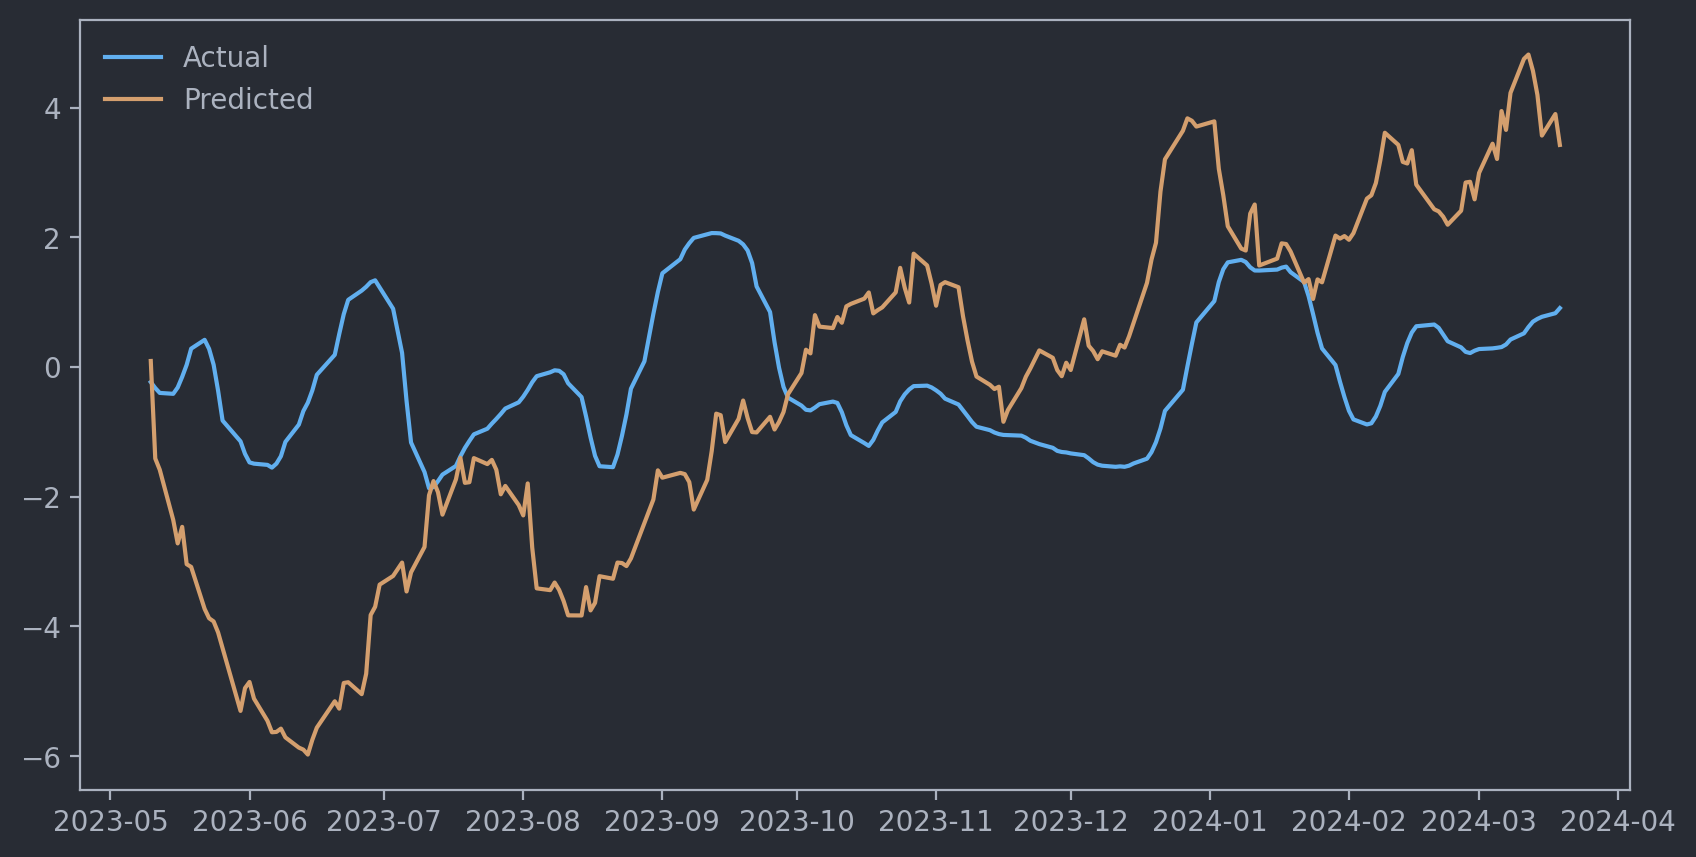

/Users/darien/miniforge3/envs/tradingScratch310/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step

R2: -0.21, MAE: 0.95, MAPE: 178.37%


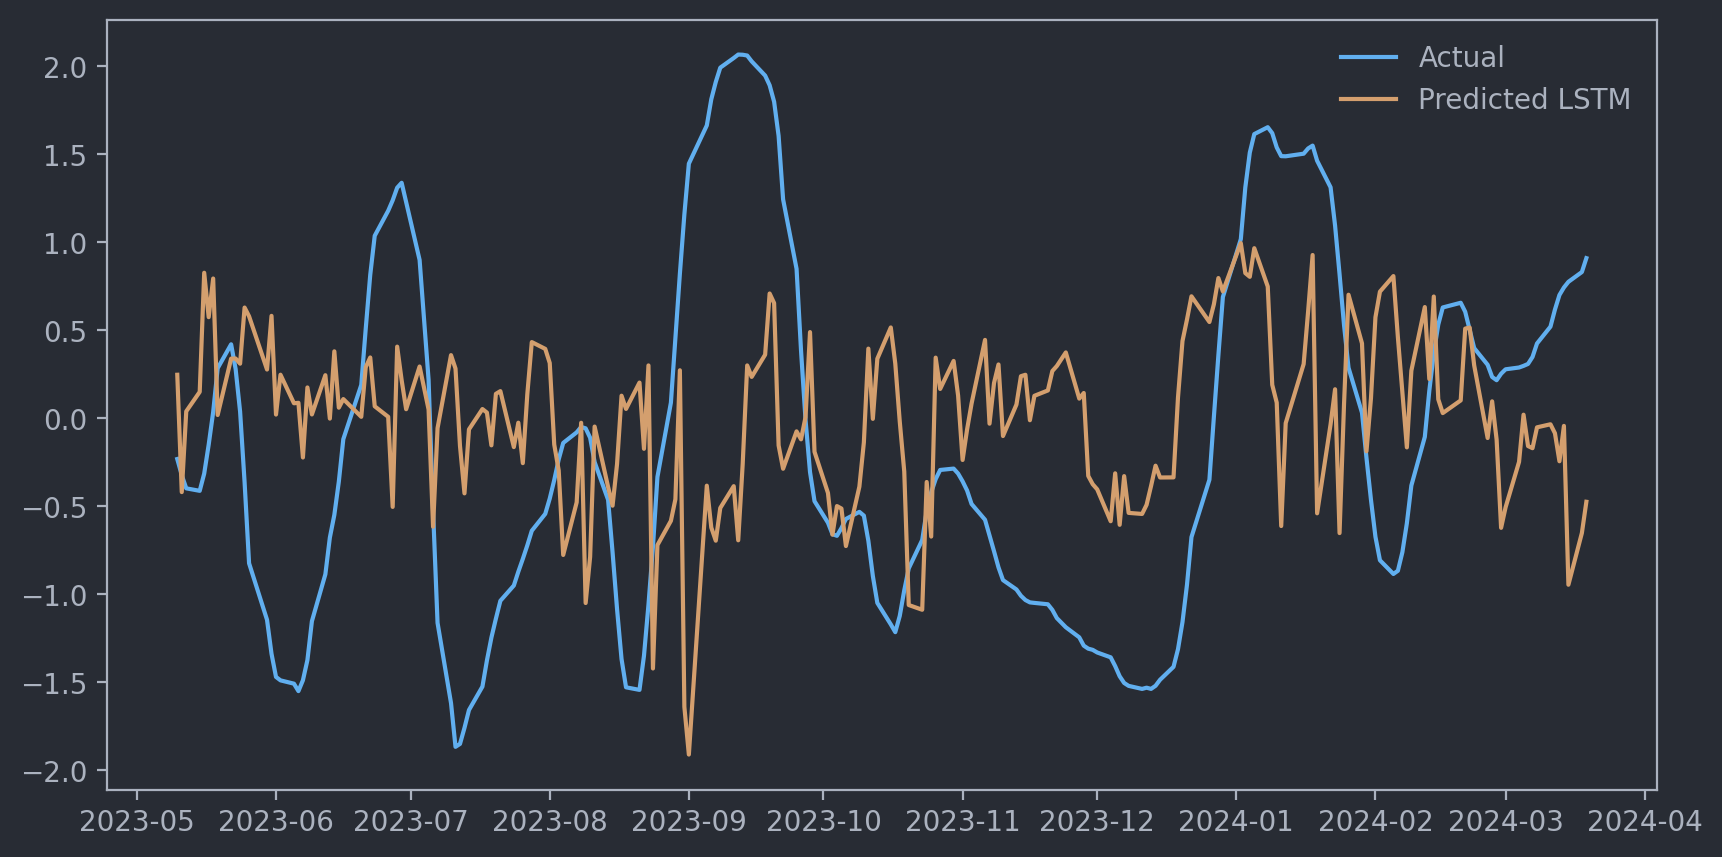

/Users/darien/miniforge3/envs/tradingScratch310/lib/python3.10/site-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step

R2: -0.14, MAE: 0.95, MAPE: 160.87%


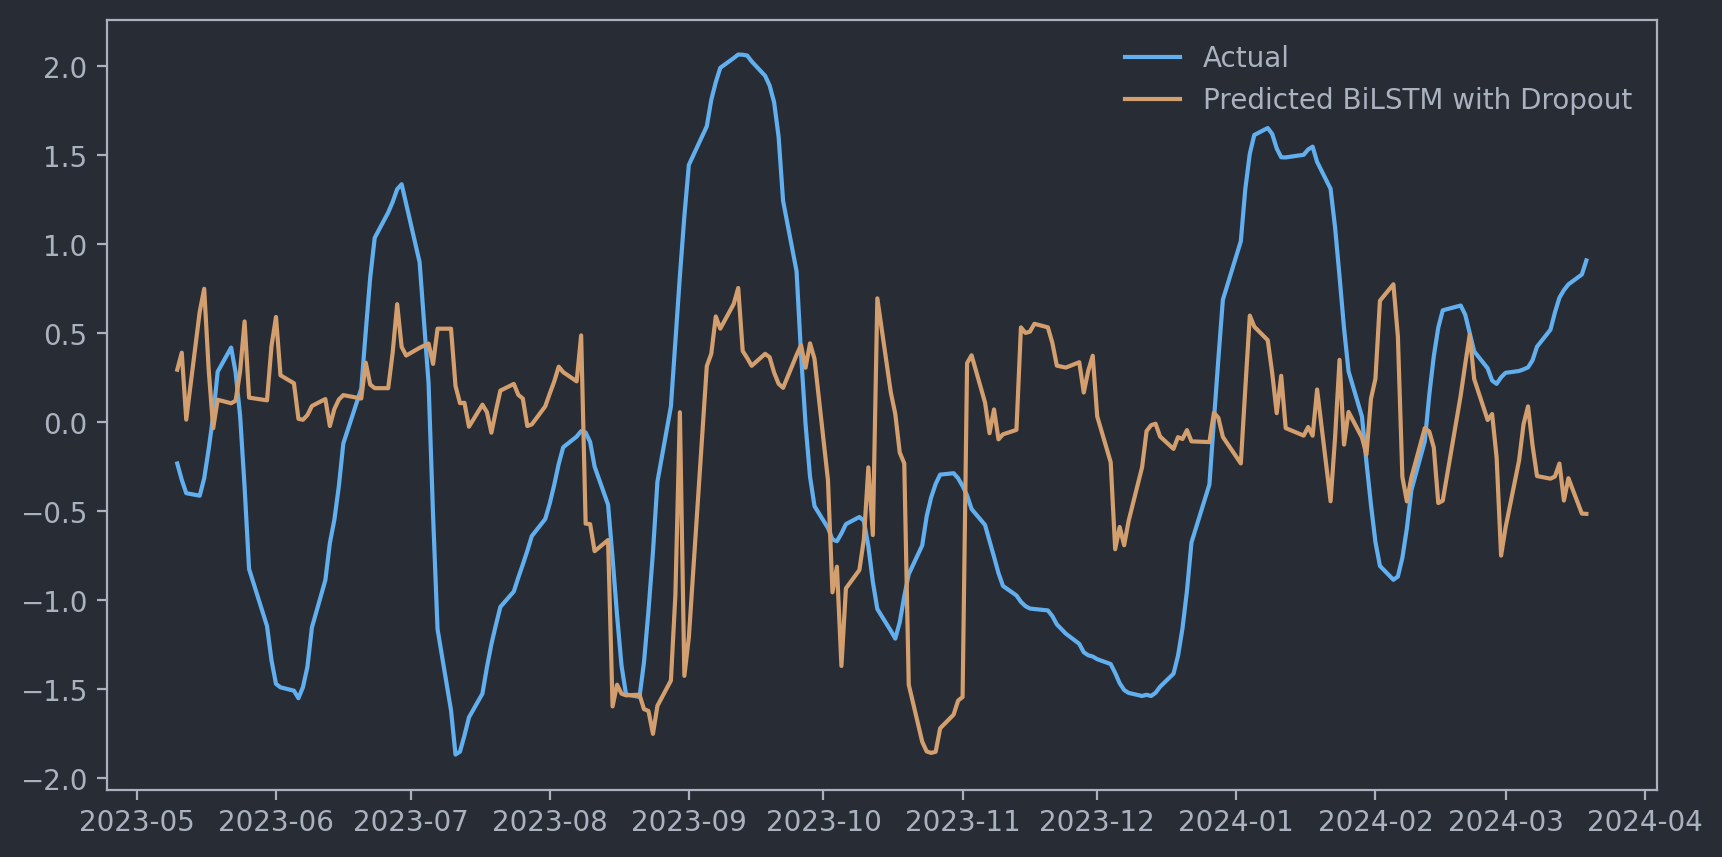

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Dropout




model_reg = LinearRegression()
model_reg.fit(X_train, y_train)

y_pred = model_reg.predict(X_test)


model_results['Regression with Feature Selection'] = calculate_metrics(y_test, y_pred)

fig = plt.figure(figsize=(10, 5))
plt.plot(y_test.index, y_test, label="Actual")
plt.plot(y_test.index, y_pred, label="Predicted")
plt.legend()

plt.show()

def calculate_padding(features, look_back):
    return (look_back - (features % look_back)) % look_back

padding_train = calculate_padding(X_train.shape[1], LOOK_BACK)
padding_test = calculate_padding(X_test.shape[1], LOOK_BACK)

# Pad both training and testing feature sets
X_train_padded = np.pad(X_train.values, ((0, 0), (0, padding_train)), 'constant', constant_values=0)
X_test_padded = np.pad(X_test.values, ((0, 0), (0, padding_test)), 'constant', constant_values=0)

# Reshape both sets for LSTM
X_train_lstm = X_train_padded.reshape((X_train.shape[0], LOOK_BACK, -1))
X_test_lstm = X_test_padded.reshape((X_test.shape[0], LOOK_BACK, -1))


# Build the LSTM model
model_lstm = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    LSTM(50),
    Dense(1)
])

model_lstm.compile(optimizer='adam', loss='mse')

# Fit the model
model_lstm.fit(X_train_lstm, y_train, epochs=200, validation_split=0.1, verbose=0)

# Predict
y_pred_lstm = model_lstm.predict(X_test_lstm)

# Evaluate
model_results['LSTM'] = calculate_metrics(y_test, y_pred_lstm.flatten())

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(y_test.index, y_test, label="Actual")
plt.plot(y_test.index, y_pred_lstm.flatten(), label="Predicted LSTM")
plt.legend()
plt.show()


# Build the Bidirectional LSTM model
model_bilstm = Sequential([
    Bidirectional(LSTM(50, return_sequences=True), input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    Dropout(0.2),  # Dropout for regularizing and preventing overfitting
    Bidirectional(LSTM(50)),
    Dropout(0.2),  # Another dropout layer after the second LSTM layer
    Dense(1)  # Output layer
])

model_bilstm.compile(optimizer='adam', loss='mse')

# Fit the model
model_bilstm.fit(X_train_lstm, y_train, epochs=200, validation_split=0.1, verbose=0)

# Predict
y_pred_bilstm = model_bilstm.predict(X_test_lstm)

# Evaluate
model_results['BiLSTM with Dropout'] = calculate_metrics(y_test, y_pred_bilstm.flatten())

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(y_test.index, y_test, label="Actual")
plt.plot(y_test.index, y_pred_bilstm.flatten(), label="Predicted BiLSTM with Dropout")
plt.legend()
plt.show()



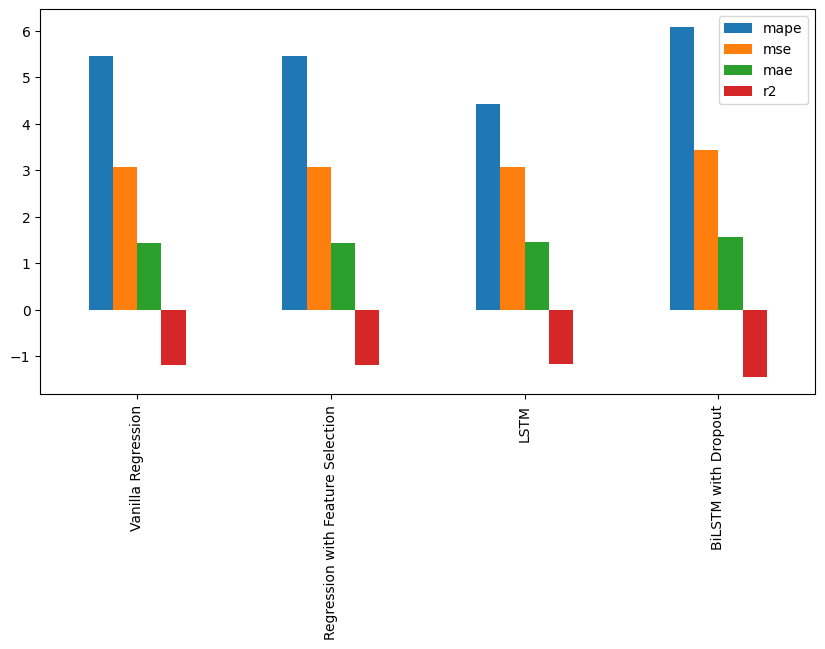

In [ ]:
# elvaluate model results to dataframe and plot bar
model_results_df = pd.DataFrame(model_results).T
model_results_df.plot(kind='bar', figsize=(10, 5))
plt.show()


['GS' 'BLK']
------Dataset Information------
Set      Size  Date Cutoff
-----  ------  -------------
Train     450  2023-01-11
Val       150  2023-08-17
Test      150  2023-08-17

R2: -4.79, MAE: 1.84, MAPE: 571.65%
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step

R2: -0.37, MAE: 0.92, MAPE: 246.05%
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step

R2: -0.36, MAE: 0.88, MAPE: 276.82%

R2: 0.19, MAE: 0.66, MAPE: 144.63%


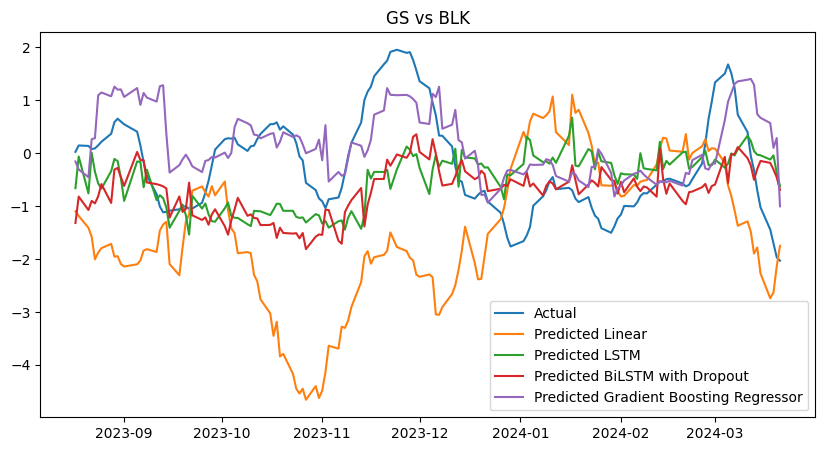

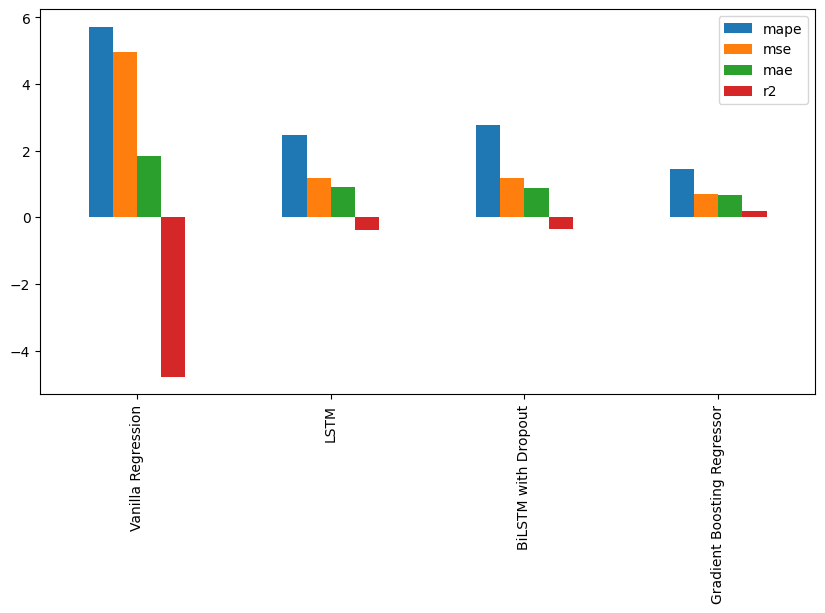

                                 mape       mse       mae        r2
Vanilla Regression           5.716538  4.946993  1.841246 -4.787359
LSTM                         2.460505  1.174393  0.915264 -0.373892
BiLSTM with Dropout          2.768214  1.165126  0.877558 -0.363050
Gradient Boosting Regressor  1.446296  0.694225  0.663984  0.187845
['JPM' 'CRM']
------Dataset Information------
Set      Size  Date Cutoff
-----  ------  -------------
Train     450  2023-01-11
Val       150  2023-08-17
Test      150  2023-08-17

R2: -19.88, MAE: 3.16, MAPE: 980.41%
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step

R2: -0.50, MAE: 0.80, MAPE: 280.66%
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step

R2: -0.18, MAE: 0.72, MAPE: 234.12%

R2: -0.27, MAE: 0.74, MAPE: 191.30%


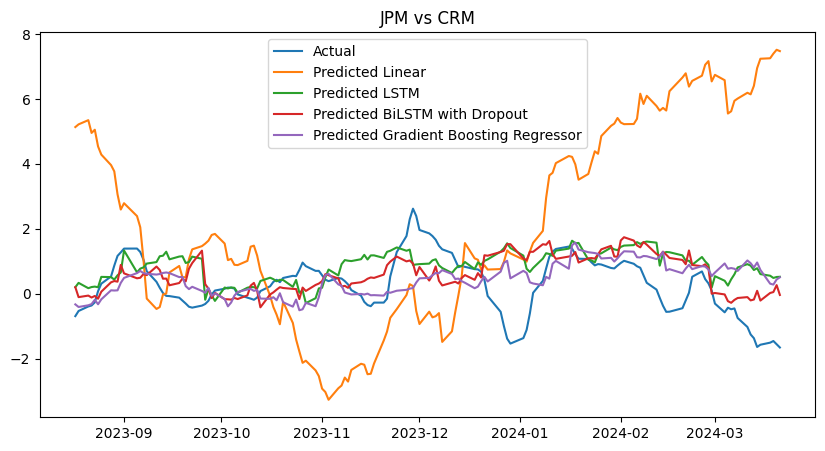

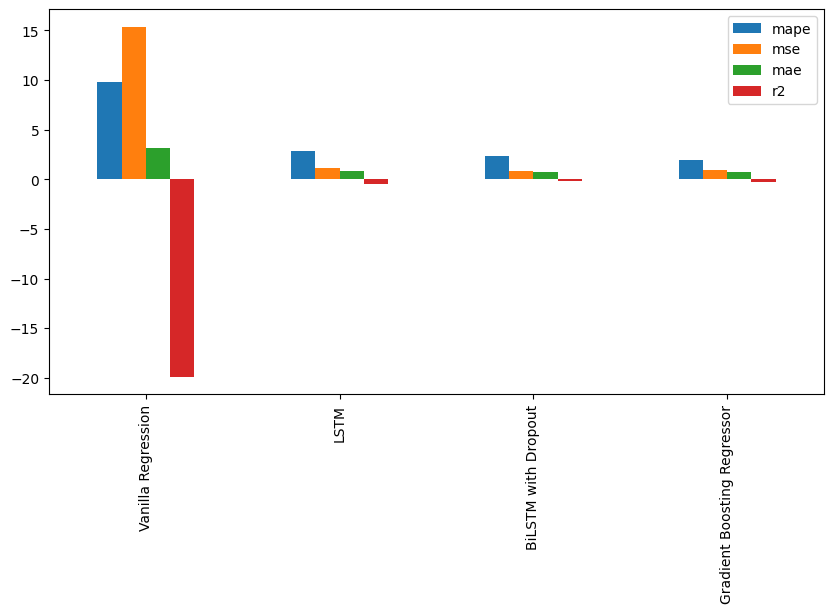

                                 mape        mse       mae         r2
Vanilla Regression           9.804092  15.353309  3.162503 -19.883126
LSTM                         2.806634   1.105743  0.804317  -0.503999
BiLSTM with Dropout          2.341172   0.869997  0.718258  -0.183345
Gradient Boosting Regressor  1.912974   0.931966  0.737315  -0.267633
['INTC' 'C']
------Dataset Information------
Set      Size  Date Cutoff
-----  ------  -------------
Train     433  2023-01-26
Val       144  2023-08-25
Test      146  2023-08-23

R2: -1728.97, MAE: 53.11, MAPE: 7047.77%


KeyboardInterrupt: 

In [11]:
#import arima
from statsmodels.tsa.arima.model import ARIMA
from sklearn.ensemble import GradientBoostingRegressor
    
# supress warnings
import warnings
warnings.filterwarnings("ignore")

SPREAD_WINDOW = None
MA_HIGH = 60
MA_LOW = 5
ADD_SENTIMENT_MA = True
# Parameters
LOOK_BACK = 5
# for each pairs, run the models
model_results = {}
result_metrics = pd.DataFrame()
for pair in pairs:
    print(pair)
    # Join Sentiment and add Sentiment Moving Averages if ADD_SENTIMENT_MA is True
    pair_sentiment_df = pd.merge( data[pair[0]].sentiment, data[pair[1]].sentiment, left_index=True, right_index=True, suffixes=("_S1", "_S2"),)
    if ADD_SENTIMENT_MA:
        pair_sentiment_df = add_moving_averages(pair_sentiment_df, [5, 10, 20], columns=pair_sentiment_df.columns)

    # Join Technical Indicators
    pair_ti_df = pd.merge( data[pair[0]].ti, data[pair[1]].ti, left_index=True, right_index=True, suffixes=("_S1", "_S2"))
    pair_df = pd.merge(pair_ti_df, pair_sentiment_df, left_index=True, right_index=True, how="left")

    # Calculate Spread
    spread = get_spread(pair_df['Adj Close_S1'], pair_df['Adj Close_S2'], window=SPREAD_WINDOW)
    pair_df['spread'] = spread

    # Calculate Moving Z score Calculation (Trading Signal)
    ma_high = pair_df.spread.rolling(window=MA_HIGH).mean()
    ma_low = pair_df.spread.rolling(window=MA_LOW).mean()
    std_high = pair_df.spread.rolling(window=MA_HIGH).std()

    moving_zscore = (ma_low - ma_high) / std_high
    pair_df['zscore_spread'] = moving_zscore

    train_data, val_data, test_data = create_dataset(
        pair_df, 
        look_back=LOOK_BACK, 
        target_col="zscore_spread", 
        drop_cols=DROP_COLS
    )

    X_train, y_train, X_val, y_val, X_test, y_test = prepare_dataset(train_data, val_data, test_data)

    # # Combine val and test data since were not using Deep learning or hyper-param tuning 
    # X_test = pd.concat([X_val, X_test])
    # y_test = pd.concat([y_val, y_test])

    model_reg = LinearRegression()
    model_reg.fit(X_train, y_train)

    y_pred_linear = model_reg.predict(X_test)

    model_results['Vanilla Regression'] = calculate_metrics(y_test, y_pred_linear)

    # # ARIMA model
    
    # arima_model = ARIMA(y_train, order=(5, 1, 0))
    # arima_model_fit = arima_model.fit()
    # y_pred_arima = arima_model_fit.forecast(len(y_test))[0]
    
    # model_results['ARIMA'] = calculate_metrics(y_test, y_pred_arima)
    
    
    
    # lstm
    padding_train = calculate_padding(X_train.shape[1], LOOK_BACK)
    padding_test = calculate_padding(X_test.shape[1], LOOK_BACK)
    
    # Pad both training and testing feature sets
    X_train_padded = np.pad(X_train.values, ((0, 0), (0, padding_train)), 'constant', constant_values=0)
    X_test_padded = np.pad(X_test.values, ((0, 0), (0, padding_test)), 'constant', constant_values=0)
    
    # Reshape both sets for LSTM
    X_train_lstm = X_train_padded.reshape((X_train.shape[0], LOOK_BACK, -1))
    X_test_lstm = X_test_padded.reshape((X_test.shape[0], LOOK_BACK, -1))
    
    # Build the LSTM model
    model_lstm = Sequential([
        LSTM(50, return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
        Dropout(0.2),  # Dropout for regularizing and preventing overfitting
        LSTM(50),
        Dense(1)  # Output layer
        
    ])
    
    model_lstm.compile(optimizer='adam', loss='mse')
    
    # Fit the model
    model_lstm.fit(X_train_lstm, y_train, epochs=100, validation_split=0.1, verbose=0)
    
    # Predict
    y_pred_lstm = model_lstm.predict(X_test_lstm)
    
    # Evaluate
    model_results['LSTM'] = calculate_metrics(y_test, y_pred_lstm.flatten())
    
    # Build the Bidirectional LSTM model
    model_bilstm = Sequential([
        Bidirectional(LSTM(50, return_sequences=True), input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
        Dropout(0.2),  # Dropout for regularizing and preventing overfitting
        Bidirectional(LSTM(50)),
        Dense(1)  # Output layer
    ])
    
    model_bilstm.compile(optimizer='adam', loss='mse')
    
    # Fit the model
    model_bilstm.fit(X_train_lstm, y_train, epochs=100, validation_split=0.1, verbose=0)
    
    # Predict
    y_pred_bilstm = model_bilstm.predict(X_test_lstm)
    
    # Evaluate
    model_results['BiLSTM with Dropout'] = calculate_metrics(y_test, y_pred_bilstm.flatten())
    
    
    # gradient boosting regessor
    model_gbr = GradientBoostingRegressor()
    model_gbr.fit(X_train, y_train)
    y_pred_gbr = model_gbr.predict(X_test)
    
    model_results['Gradient Boosting Regressor'] = calculate_metrics(y_test, y_pred_gbr)
    
    
    
    # plot all together and show one loop in one plot

    plt.figure(figsize=(10, 5))
    plt.title(f'{pair[0]} vs {pair[1]}')
    plt.plot(y_test.index, y_test, label="Actual")
    plt.plot(y_test.index, y_pred_linear, label="Predicted Linear")
    plt.plot(y_test.index, y_pred_lstm.flatten(), label="Predicted LSTM")
    plt.plot(y_test.index, y_pred_bilstm.flatten(), label="Predicted BiLSTM with Dropout")
    plt.plot(y_test.index, y_pred_gbr, label="Predicted Gradient Boosting Regressor")
    plt.legend()
    plt.show()
    
    # elvaluate model results to dataframe and plot bar
    model_results_df = pd.DataFrame(model_results).T
    model_results_df.plot(kind='bar', figsize=(10, 5))
    plt.show()
    
    # print model results
    print(model_results_df)
    
    # save pickle
    
    model_results_df.to_pickle(f'../data/model_results/{pair[0]}_{pair[1]}_model_results.pkl')
    
    model_results_df['pair'] = f'{pair[0]}_{pair[1]}'
    result_metrics = pd.concat([result_metrics, model_results_df])
    
    

In [54]:
# do a grid search on the lstm and bilstm models on pairs[15]

import numpy as np
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV

# Function to create the LSTM model for grid search
def create_lstm_model(units=50,  dropout_rate=0.2, optimizer='adam'):
    model = Sequential([
        LSTM(units, input_shape=(LOOK_BACK, int((X_train.shape[1] + padding_train) / LOOK_BACK))),
        Dropout(dropout_rate),
        LSTM(units, input_shape=(LOOK_BACK, int((X_train.shape[1] + padding_train) / LOOK_BACK))),
        Dense(1)
    ])
    model.compile(loss='mse', optimizer=optimizer)
    return model

# Function to create the BiLSTM model for grid search
def create_bilstm_model(units=50, dropout_rate=0.2, optimizer='adam'):
    model = Sequential([
        Bidirectional(LSTM(units, return_sequences=True), input_shape=(LOOK_BACK, int((X_train.shape[1] + padding_train) / LOOK_BACK))),
        Dropout(dropout_rate),
        Bidirectional(LSTM(units)),
        Dropout(dropout_rate),
        Dense(1)
    ])
    model.compile(loss='mse', optimizer=optimizer)
    return model

# Setting up the grid search parameters
param_grid = {
    'model_units': [30, 50, 70],
    'model_optimizer': ['adam', 'rmsprop'],
    'epochs': [50, 100]
}

# Create the KerasRegressor model for the LSTM
model = KerasRegressor(model=create_lstm_model, verbose=0, lr=None, optimizer=None)
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
grid_result = grid.fit(X_train_lstm, y_train)

# Print the best parameters and best score
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# Create the KerasRegressor model for the BiLSTM
model_bilstm = KerasRegressor(build_fn=create_bilstm_model, verbose=0)
grid_bilstm = GridSearchCV(estimator=model_bilstm, param_grid=param_grid, cv=3)
grid_result_bilstm = grid_bilstm.fit(X_train_lstm, y_train)

# Print the best parameters and best score for BiLSTM
print("Best: %f using %s" % (grid_result_bilstm.best_score_, grid_result_bilstm.best_params_))




ValueError: Invalid parameter model_optimizer for estimator KerasRegressor.
This issue can likely be resolved by setting this parameter in the KerasRegressor constructor:
`KerasRegressor(model_optimizer=adam)`
Check the list of available parameters with `estimator.get_params().keys()`

In [53]:
pip install keras==2.12.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 1.8 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: keras
    Found existing installation: keras 3.1.1
    Uninstalling keras-3.1.1:
      Successfully uninstalled keras-3.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.16.1 requires keras>=3.0.0, but you have keras 2.12.0 which is incompatible.
Note: you may need to restart the kernel to use updated packages.
